## Skincancer classification using balanced dataset of size 250 samples each

### Part 2 - Training a simple CNN (Convolutional Neural Network)

#### Experiment 1: 

Training & testing a simple CNN model with balanced data set of 250 samples each with an input size 256 x 256 x 3 and a batch size of 16

Reading input data from "skinlesion_250_split" dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob #to walk through folder structure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#2 -> Filter out INFO & WARNING messages 
tf.autograph.set_verbosity(0)

In [2]:
batch_size = 32
img_height = 256
img_width = 256

train_dir = 'data/skinlesion_250_split/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1225 files belonging to 7 classes.
Metal device set to: Apple M2


2022-12-10 00:57:34.339044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 00:57:34.339294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
val_dir = 'data/skinlesion_250_split/val'
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 350 files belonging to 7 classes.


In [4]:
test_dir = 'data/skinlesion_250_split/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 175 files belonging to 7 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


2022-12-10 00:57:34.482710: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


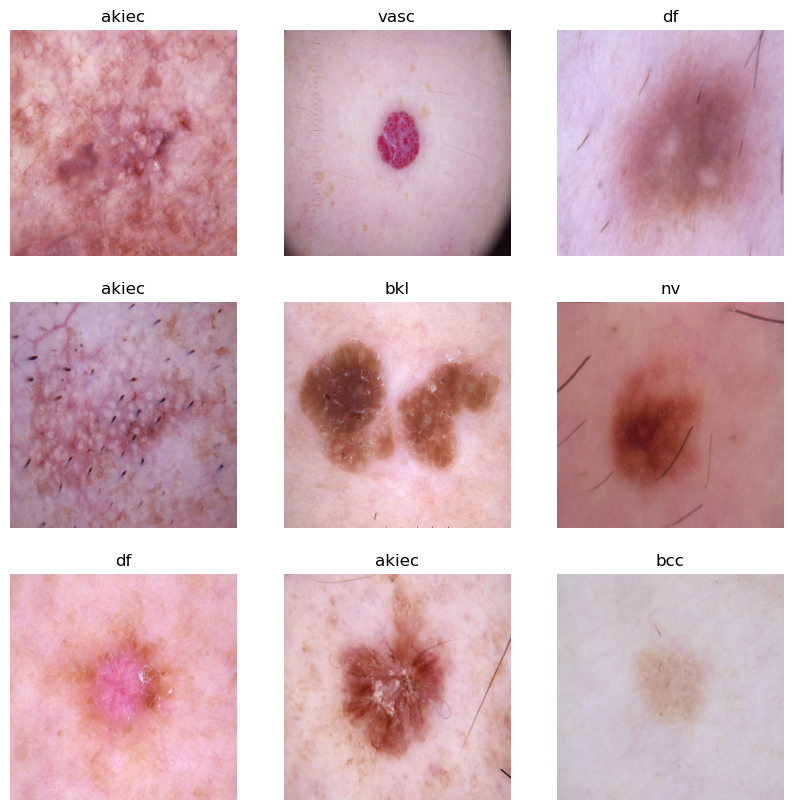

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
##configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
#model build
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        1

In [9]:
print("Number of layers in the model:",len(model.layers))

Number of layers in the model: 10


In [10]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=5,min_delta=0.001)

checkpoint_filepath = 'models/skinlesion250_cnn1_256_16.h5' #simple cnn model,inputsize 256*256,batchsize 16
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_accuracy',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es,mc])

Epoch 1/50


2022-12-10 00:57:36.077423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 1.9921 - accuracy: 0.1314

2022-12-10 00:58:06.266639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 32s 793ms/step - loss: 1.9921 - accuracy: 0.1314 - val_loss: 1.9466 - val_accuracy: 0.1429
Epoch 2/50
39/39 [==============================] - 27s 686ms/step - loss: 1.9466 - accuracy: 0.1461 - val_loss: 1.9285 - val_accuracy: 0.2114
Epoch 3/50
39/39 [==============================] - 27s 683ms/step - loss: 1.9381 - accuracy: 0.1682 - val_loss: 1.8950 - val_accuracy: 0.1629
Epoch 4/50
39/39 [==============================] - 28s 719ms/step - loss: 1.8480 - accuracy: 0.2163 - val_loss: 1.9051 - val_accuracy: 0.2114
Epoch 5/50
39/39 [==============================] - 27s 699ms/step - loss: 1.7676 - accuracy: 0.2776 - val_loss: 1.8114 - val_accuracy: 0.2543
Epoch 6/50
39/39 [==============================] - 28s 710ms/step - loss: 1.6660 - accuracy: 0.3380 - val_loss: 1.8235 - val_accuracy: 0.2771
Epoch 7/50
39/39 [==============================] - 28s 728ms/step - loss: 1.6136 - accuracy: 0.3616 - val_loss: 1.7936 - val_accuracy: 0.2829
Epoch 8/50

### Visualising training performance

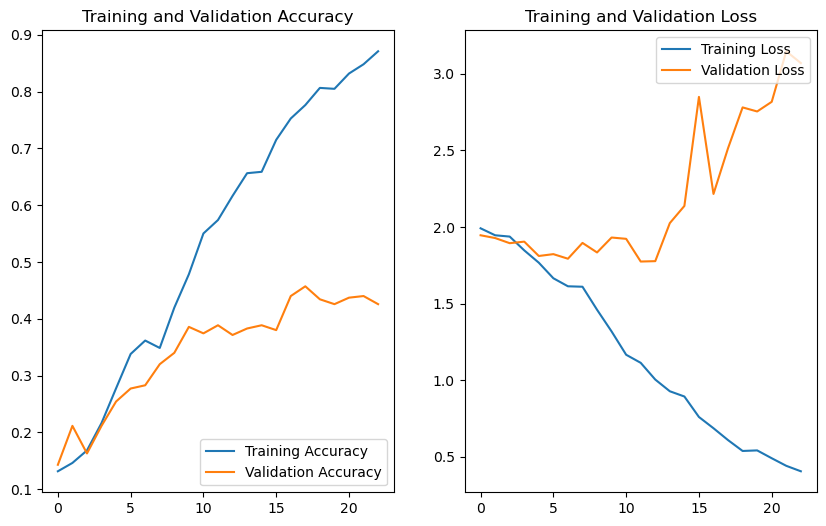

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis:
The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

### Using model for inference on test data

In [164]:
y_true =  []
y_preds =[]
y_test_proba = np.array([],dtype=np.float32).reshape(0,7)

for img_batch,label_batch in test_ds:
    
    test_preds_proba = model.predict(img_batch)
    y_test_proba=np.concatenate((y_test_proba,test_preds_proba),axis=0)
    
    test_pred = np.argmax(test_preds_proba,axis=-1)
    
    for i in range(len(label_batch)):
        test_label = class_names[label_batch[i]]
        y_true.append(test_label)
        pred_class = class_names[test_pred[i]]
        y_preds.append(pred_class)
print(len(y_true))
print(len(y_preds))
print(y_test_proba.shape)

1/1 [==============================] - 0s 13ms/step
175
175
(175, 7)


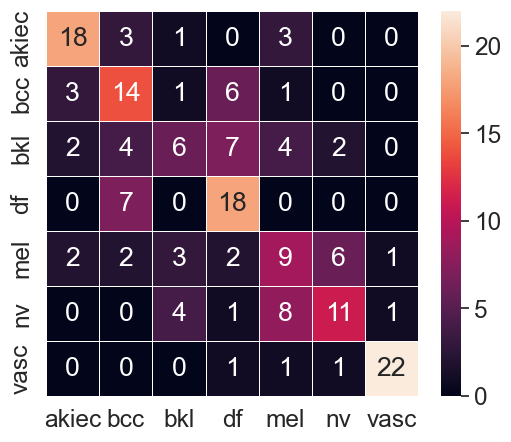

In [75]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_preds)
fig, ax = plt.subplots(figsize=(6,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
fig.show()

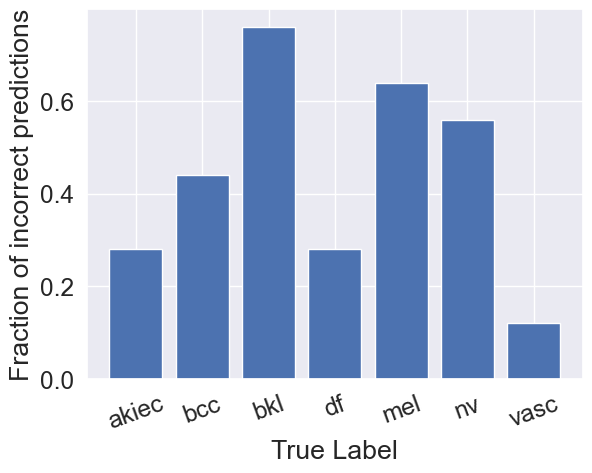

In [169]:
#PLot fractional incorrect misclassifications
# plt.figure(figsize=(6,5))
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks([0,1,2,3,4,5,6], class_names,rotation=20)
plt.show()

1/1 [==============================] - 0s 13ms/step


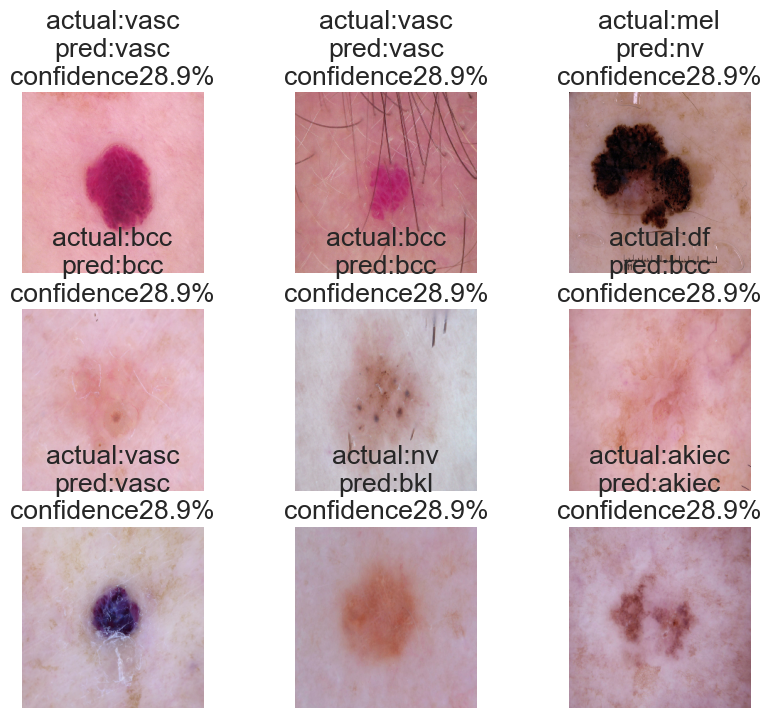

In [94]:
plt.figure(figsize=(10, 8))
for img_batch, label_batch in test_ds.take(1):
    predictions = model.predict(img_batch)
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        pred_class = class_names[np.argmax(predictions[i])]
        pred_score = tf.nn.softmax(predictions[i])
        percent = round(100*np.max(pred_score), 2)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title("actual:"+class_names[label_batch[i]]+"\npred:"+pred_class+"\nconfidence"+str(percent)+"%")
        plt.axis("off")
        plt.tight_layout

In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_preds,labels=class_names))

              precision    recall  f1-score   support

       akiec       0.72      0.72      0.72        25
         bcc       0.47      0.56      0.51        25
         bkl       0.40      0.24      0.30        25
          df       0.51      0.72      0.60        25
         mel       0.35      0.36      0.35        25
          nv       0.55      0.44      0.49        25
        vasc       0.92      0.88      0.90        25

    accuracy                           0.56       175
   macro avg       0.56      0.56      0.55       175
weighted avg       0.56      0.56      0.55       175



In [97]:
#validation check
val_true =  []
val_preds =[]
for img_batch,label_batch in val_ds:
    val_pred = np.argmax(model.predict(img_batch),axis=-1)
    
    for i in range(len(label_batch)):
        val_label = class_names[label_batch[i]]
        val_true.append(val_label)
        pred_class = class_names[val_pred[i]]
        val_preds.append(pred_class)
print(len(val_true))
print(len(val_preds))

1/1 [==============================] - 0s 59ms/step
350
350


In [100]:
print(classification_report(val_true,val_preds,labels=class_names))

              precision    recall  f1-score   support

       akiec       0.42      0.42      0.42        50
         bcc       0.29      0.36      0.32        50
         bkl       0.38      0.22      0.28        50
          df       0.45      0.68      0.54        50
         mel       0.32      0.40      0.36        50
          nv       0.37      0.26      0.31        50
        vasc       0.91      0.64      0.75        50

    accuracy                           0.43       350
   macro avg       0.45      0.43      0.42       350
weighted avg       0.45      0.43      0.42       350



In [174]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize

In [116]:
classes = np.unique(y_true)

In [110]:
y_test_binarized = label_binarize(y_true,classes=np.unique(y_true)) #binarising list object

In [171]:
y_test_binarized.shape

(175, 7)

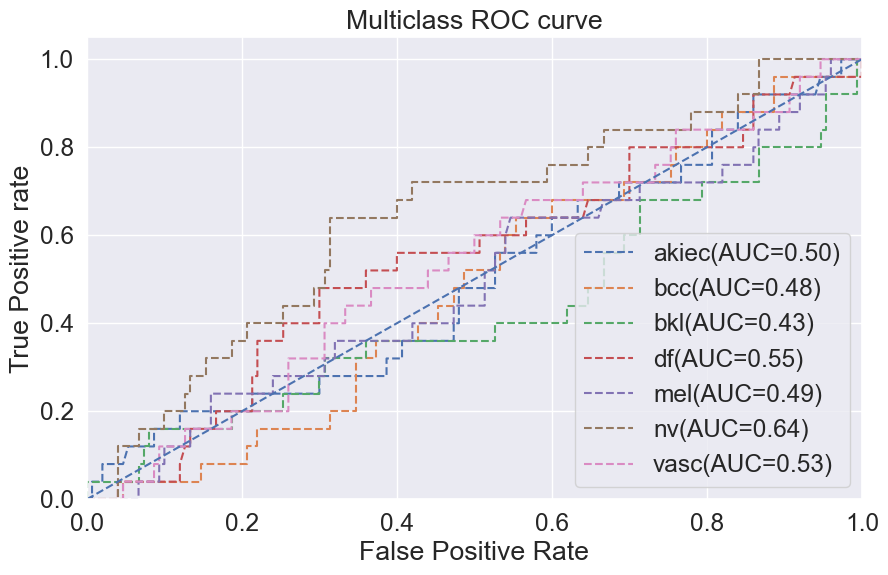

In [173]:
#roc curve for all classes
fpr ={}
tpr={}
thresh ={}
roc_auc=dict()

plt.figure(figsize=(10,6))

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_test_proba[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s(AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [175]:
roc_auc_score(y_test_binarized,y_test_proba,multi_class='ovr')

0.5168

### Comments:

1. clear case of over fitting - so tackle model first, then i can experiment with input size

Re define model with one layer of batch normalisation and one drop out after dense 

In [179]:
# Model 2 build
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)       

In [181]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=5,min_delta=0.001)

checkpoint_filepath = 'models/skinlesion250_cnn2_256_16.h5' #simple cnn model 2,inputsize 256*256,batchsize 32
mc = ModelCheckpoint(filepath=checkpoint_filepath,
                     monitor='val_accuracy',
                    save_weights_only=True,
                    save_best_only=True,
                    mode='max')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [182]:
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es,mc])

Epoch 1/50


2022-12-10 18:07:48.376290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.0858 - accuracy: 0.1853

2022-12-10 18:08:14.783930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 29s 721ms/step - loss: 2.0858 - accuracy: 0.1853 - val_loss: 1.9459 - val_accuracy: 0.1400
Epoch 2/50
39/39 [==============================] - 27s 683ms/step - loss: 1.9114 - accuracy: 0.1837 - val_loss: 2.0137 - val_accuracy: 0.1457
Epoch 3/50
39/39 [==============================] - 28s 715ms/step - loss: 1.9067 - accuracy: 0.1943 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 4/50
39/39 [==============================] - 27s 696ms/step - loss: 1.8463 - accuracy: 0.2229 - val_loss: 1.9452 - val_accuracy: 0.1486
Epoch 5/50
39/39 [==============================] - 26s 691ms/step - loss: 1.8430 - accuracy: 0.2204 - val_loss: 1.8929 - val_accuracy: 0.2286
Epoch 6/50
39/39 [==============================] - 27s 685ms/step - loss: 1.8390 - accuracy: 0.2449 - val_loss: 1.9384 - val_accuracy: 0.1600
Epoch 7/50
39/39 [==============================] - 27s 683ms/step - loss: 1.8166 - accuracy: 0.2506 - val_loss: 1.9742 - val_accuracy: 0.1829
Epoch 8/50

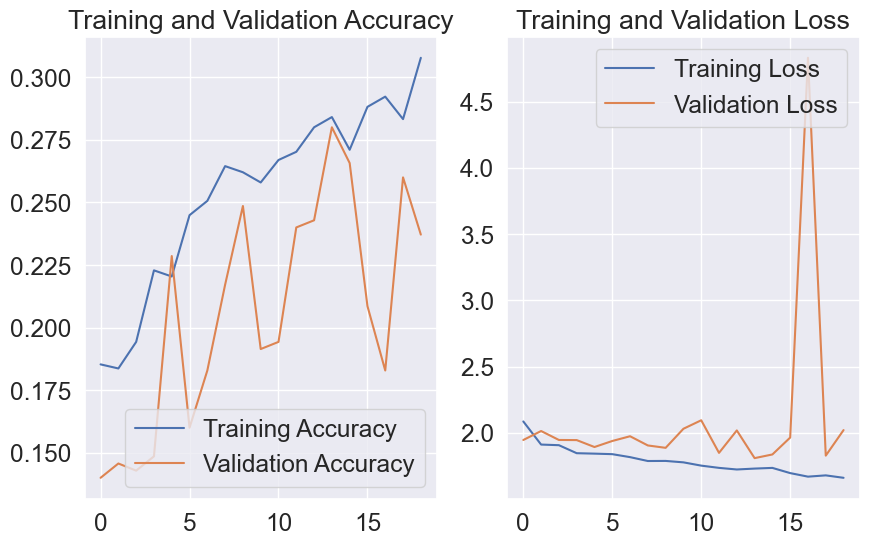

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [185]:
# Model 2 build - 2 batch normalisation layers ,2 drop out
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 64)      

In [186]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 18:20:27.307627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.1893 - accuracy: 0.1576

2022-12-10 18:20:53.562032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 29s 722ms/step - loss: 2.1893 - accuracy: 0.1576 - val_loss: 4.1677 - val_accuracy: 0.1429
Epoch 2/50
39/39 [==============================] - 28s 719ms/step - loss: 1.9456 - accuracy: 0.1429 - val_loss: 4.2111 - val_accuracy: 0.1429
Epoch 3/50
39/39 [==============================] - 28s 707ms/step - loss: 1.9589 - accuracy: 0.1306 - val_loss: 5.4968 - val_accuracy: 0.1457
Epoch 4/50
39/39 [==============================] - 27s 681ms/step - loss: 1.9461 - accuracy: 0.1429 - val_loss: 7.0338 - val_accuracy: 0.1457
Epoch 5/50
39/39 [==============================] - 28s 713ms/step - loss: 1.9461 - accuracy: 0.1282 - val_loss: 7.2894 - val_accuracy: 0.1571
Epoch 6/50
39/39 [==============================] - 27s 699ms/step - loss: 1.9461 - accuracy: 0.1429 - val_loss: 6.4801 - val_accuracy: 0.1400
Epoch 7/50
39/39 [==============================] - 27s 701ms/step - loss: 1.9461 - accuracy: 0.1322 - val_loss: 5.0603 - val_accuracy: 0.1257
Epoch 8/50

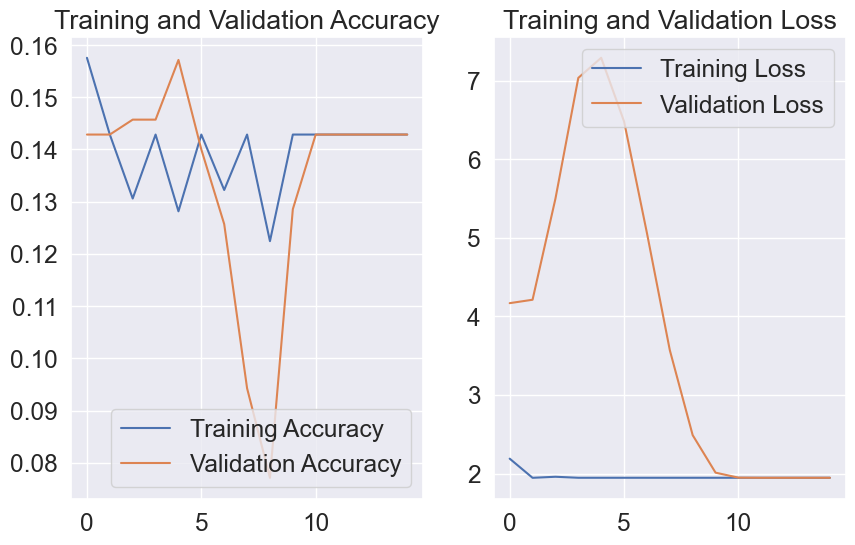

In [187]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Comments:
Accuracy dropped quite drastically - meaning model is not learning correct features - to tackle - either modify model architecture by increasing number of layers in conv filters, and/or change input with sizes and augmentation 

first lets try - inputs modification 

### Experiment 3 - changing input image size - 128x128x3

In [5]:
batch_size = 32
img_height = 128
img_width = 128

train_dir = 'data/skinlesion_250_split/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dir = 'data/skinlesion_250_split/val'
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)    

Found 1225 files belonging to 7 classes.
Found 350 files belonging to 7 classes.


In [2]:
def generate_data(batch_size,img_height,img_width,data_dir):
    train_dir = data_dir +'/train'
    train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                          labels='inferred',
                          seed=123,
                          image_size=(img_height, img_width),
                          batch_size=batch_size)

    val_dir = data_dir +'/val'
    val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                          labels='inferred',
                          seed=123,
                          image_size=(img_height, img_width),
                          batch_size=batch_size)
    return train_ds,val_ds

In [192]:
#model 1 build - with 1 layer of batch normalisation
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)       

In [193]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 18:32:45.821391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 1.9303 - accuracy: 0.2073

2022-12-10 18:32:51.572107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 7s 151ms/step - loss: 1.9303 - accuracy: 0.2073 - val_loss: 1.9447 - val_accuracy: 0.1543
Epoch 2/50
39/39 [==============================] - 6s 140ms/step - loss: 1.8410 - accuracy: 0.2384 - val_loss: 1.9227 - val_accuracy: 0.2457
Epoch 3/50
39/39 [==============================] - 6s 141ms/step - loss: 1.7646 - accuracy: 0.3053 - val_loss: 1.9498 - val_accuracy: 0.2086
Epoch 4/50
39/39 [==============================] - 6s 142ms/step - loss: 1.6121 - accuracy: 0.3755 - val_loss: 1.8669 - val_accuracy: 0.1971
Epoch 5/50
39/39 [==============================] - 6s 142ms/step - loss: 1.4538 - accuracy: 0.4506 - val_loss: 1.8160 - val_accuracy: 0.3114
Epoch 6/50
39/39 [==============================] - 6s 143ms/step - loss: 1.3138 - accuracy: 0.4947 - val_loss: 1.7440 - val_accuracy: 0.3086
Epoch 7/50
39/39 [==============================] - 6s 145ms/step - loss: 1.2167 - accuracy: 0.5331 - val_loss: 1.9871 - val_accuracy: 0.2514
Epoch 8/50
39/39 

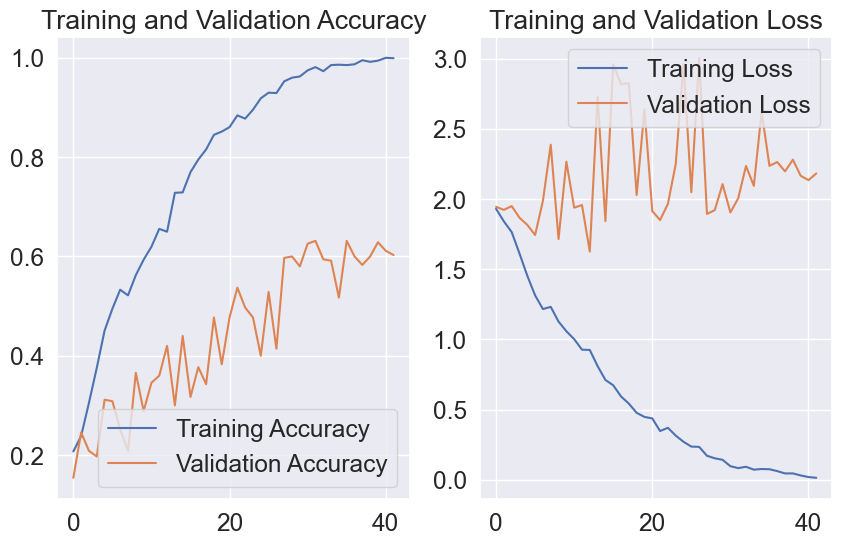

In [195]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(42)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clearly overfitting - add a dropout layer 

In [197]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)       

In [199]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 18:43:35.884683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 1.8799 - accuracy: 0.2220

2022-12-10 18:43:41.322870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 6s 151ms/step - loss: 1.8799 - accuracy: 0.2220 - val_loss: 1.9342 - val_accuracy: 0.1486
Epoch 2/50
39/39 [==============================] - 6s 140ms/step - loss: 1.7264 - accuracy: 0.2816 - val_loss: 1.9042 - val_accuracy: 0.2314
Epoch 3/50
39/39 [==============================] - 6s 141ms/step - loss: 1.5834 - accuracy: 0.3494 - val_loss: 1.8657 - val_accuracy: 0.2057
Epoch 4/50
39/39 [==============================] - 6s 142ms/step - loss: 1.4789 - accuracy: 0.3837 - val_loss: 1.8914 - val_accuracy: 0.2343
Epoch 5/50
39/39 [==============================] - 6s 142ms/step - loss: 1.4415 - accuracy: 0.4114 - val_loss: 1.7053 - val_accuracy: 0.3457
Epoch 6/50
39/39 [==============================] - 6s 141ms/step - loss: 1.3829 - accuracy: 0.4376 - val_loss: 1.6894 - val_accuracy: 0.3171
Epoch 7/50
39/39 [==============================] - 6s 140ms/step - loss: 1.3515 - accuracy: 0.4449 - val_loss: 1.6753 - val_accuracy: 0.3429
Epoch 8/50
39/39 

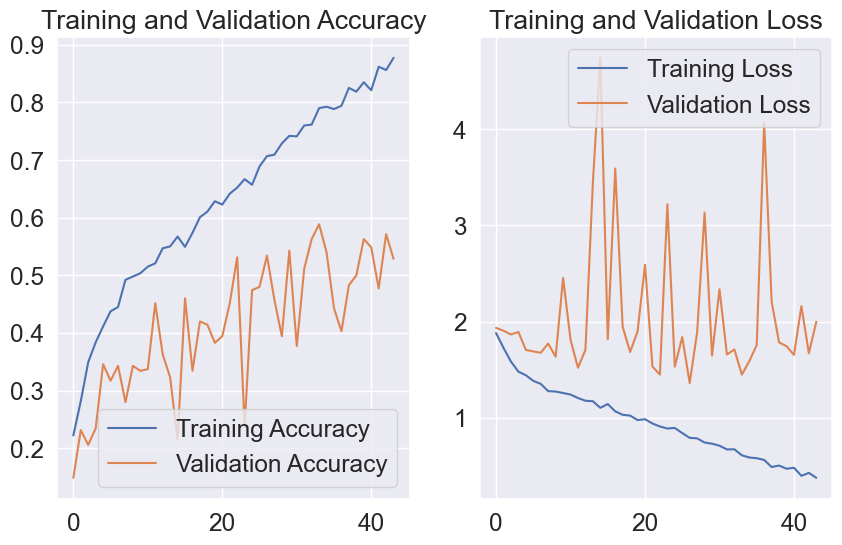

In [201]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(44)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Decreasing size of input - 

Try same network with data augmentation to see if performance improves

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [12]:
img_height =128
img_width =128
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2), #tested with 0.3 -too much fluctuation in val performance
    layers.RandomZoom(0.2),
  ]
)

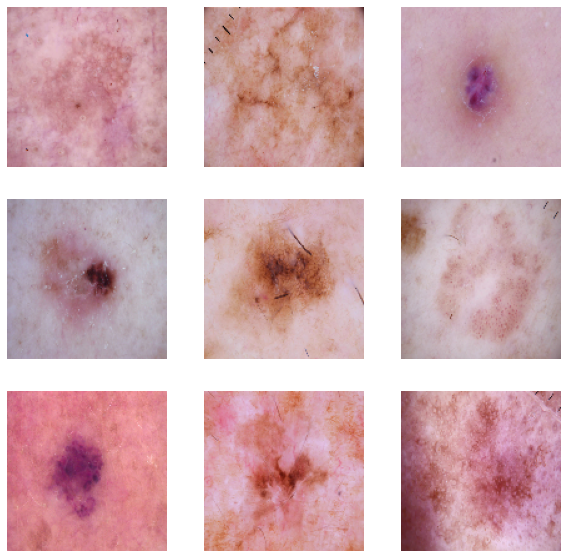

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")

In [4]:
## model with 1 bath norm and 1 drop out, data augmentation 
num_classes = 7
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [16]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 20:24:13.204712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 1.9462 - accuracy: 0.2106

2022-12-10 20:24:28.579081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 17s 399ms/step - loss: 1.9462 - accuracy: 0.2106 - val_loss: 1.9779 - val_accuracy: 0.1543
Epoch 2/50
39/39 [==============================] - 16s 396ms/step - loss: 1.8743 - accuracy: 0.2465 - val_loss: 1.9274 - val_accuracy: 0.2057
Epoch 3/50
39/39 [==============================] - 16s 392ms/step - loss: 1.7650 - accuracy: 0.3110 - val_loss: 1.9232 - val_accuracy: 0.1743
Epoch 4/50
39/39 [==============================] - 16s 395ms/step - loss: 1.7058 - accuracy: 0.3314 - val_loss: 1.9379 - val_accuracy: 0.1829
Epoch 5/50
39/39 [==============================] - 15s 389ms/step - loss: 1.5913 - accuracy: 0.3608 - val_loss: 1.8764 - val_accuracy: 0.2657
Epoch 6/50
39/39 [==============================] - 15s 390ms/step - loss: 1.5506 - accuracy: 0.3812 - val_loss: 1.9754 - val_accuracy: 0.2371
Epoch 7/50
39/39 [==============================] - 16s 395ms/step - loss: 1.5222 - accuracy: 0.4212 - val_loss: 1.7685 - val_accuracy: 0.2371
Epoch 8/50

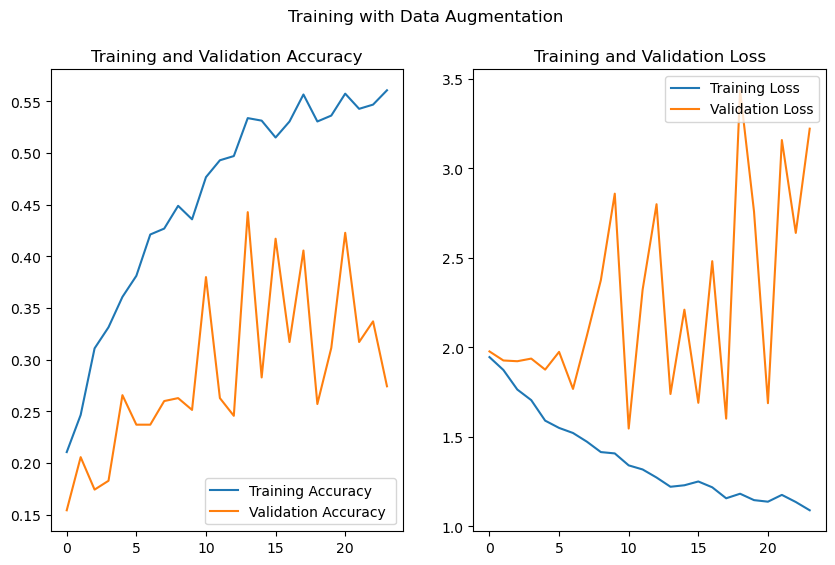

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(24)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy ')
plt.legend(loc='lower right',fontsize=10)
plt.title('Training and Validation Accuracy',fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right',fontsize=10)
plt.title('Training and Validation Loss',fontsize=12)
plt.suptitle('Training with Data Augmentation',fontsize=12)
plt.show()

In [12]:
## using different input image size and smaller batch size - as dataset is small -learning will be more gradual
batch_size =16
img_height =256
img_width =256
data_dir = 'data/skinlesion_250_split'
train_dir = data_dir +'/train'
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                              labels='inferred',
                              seed=123,
                              image_size=(img_height, img_width),
                              batch_size=batch_size)

val_dir = data_dir +'/val'
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                              labels='inferred',
                              seed=123,
                              image_size=(img_height, img_width),
                              batch_size=batch_size)

Found 1225 files belonging to 7 classes.
Found 350 files belonging to 7 classes.


In [13]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 20:53:18.702825: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 20:53:18.704897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - ETA: 0s - loss: 2.1141 - accuracy: 0.1380

2022-12-10 20:53:50.565851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 34s 422ms/step - loss: 2.1141 - accuracy: 0.1380 - val_loss: 2.4148 - val_accuracy: 0.1429
Epoch 2/50
77/77 [==============================] - 32s 417ms/step - loss: 1.9483 - accuracy: 0.1249 - val_loss: 1.9476 - val_accuracy: 0.1343
Epoch 3/50
77/77 [==============================] - 32s 416ms/step - loss: 1.9447 - accuracy: 0.1249 - val_loss: 1.9315 - val_accuracy: 0.2114
Epoch 4/50
77/77 [==============================] - 32s 415ms/step - loss: 1.9448 - accuracy: 0.1339 - val_loss: 2.4166 - val_accuracy: 0.1429
Epoch 5/50
77/77 [==============================] - 32s 415ms/step - loss: 1.9428 - accuracy: 0.1347 - val_loss: 2.1930 - val_accuracy: 0.1514
Epoch 6/50
77/77 [==============================] - 32s 417ms/step - loss: 1.9438 - accuracy: 0.1445 - val_loss: 1.9504 - val_accuracy: 0.1457
Epoch 7/50
77/77 [==============================] - 32s 415ms/step - loss: 1.9447 - accuracy: 0.1314 - val_loss: 2.7334 - val_accuracy: 0.1371
Epoch 8/50

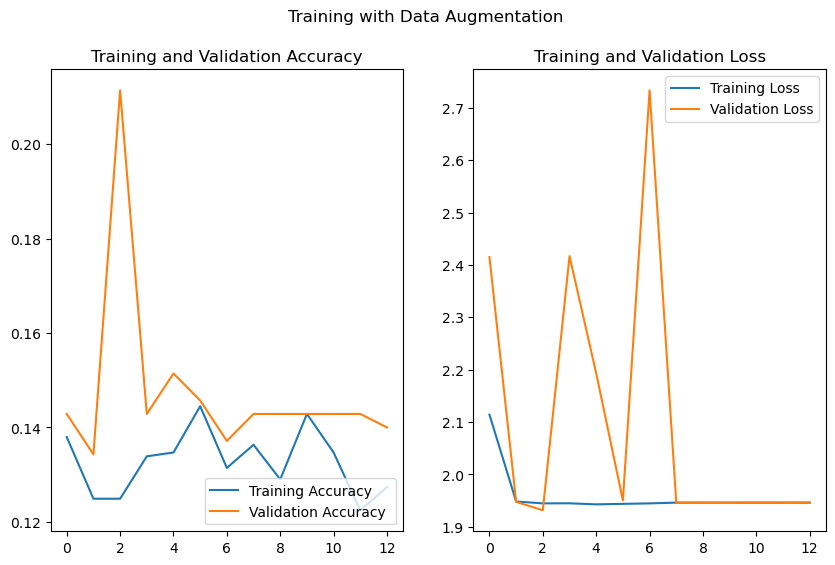

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy ')
plt.legend(loc='lower right',fontsize=10)
plt.title('Training and Validation Accuracy',fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right',fontsize=10)
plt.title('Training and Validation Loss',fontsize=12)
plt.suptitle('Training with Data Augmentation',fontsize=12)
plt.show()

In [15]:
# since model is not sufficiently trained - i will train it for 25 epochs to confirm 

extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 13/37
77/77 [==============================] - 33s 422ms/step - loss: 1.9462 - accuracy: 0.1265 - val_loss: 1.9460 - val_accuracy: 0.1400
Epoch 14/37
77/77 [==============================] - 32s 415ms/step - loss: 1.9461 - accuracy: 0.1110 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 15/37
77/77 [==============================] - 32s 416ms/step - loss: 1.9461 - accuracy: 0.1265 - val_loss: 1.9461 - val_accuracy: 0.1400
Epoch 16/37
77/77 [==============================] - 32s 415ms/step - loss: 1.9461 - accuracy: 0.1167 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 17/37
77/77 [==============================] - 32s 414ms/step - loss: 1.9462 - accuracy: 0.1200 - val_loss: 1.9461 - val_accuracy: 0.1400
Epoch 18/37
77/77 [==============================] - 32s 416ms/step - loss: 1.9633 - accuracy: 0.1135 - val_loss: 166.4641 - val_accuracy: 0.1429
Epoch 19/37
77/77 [==============================] - 32s 416ms/step - loss: 1.9652 - accuracy: 0.1241 - val_loss: 15.0324 - val_accura

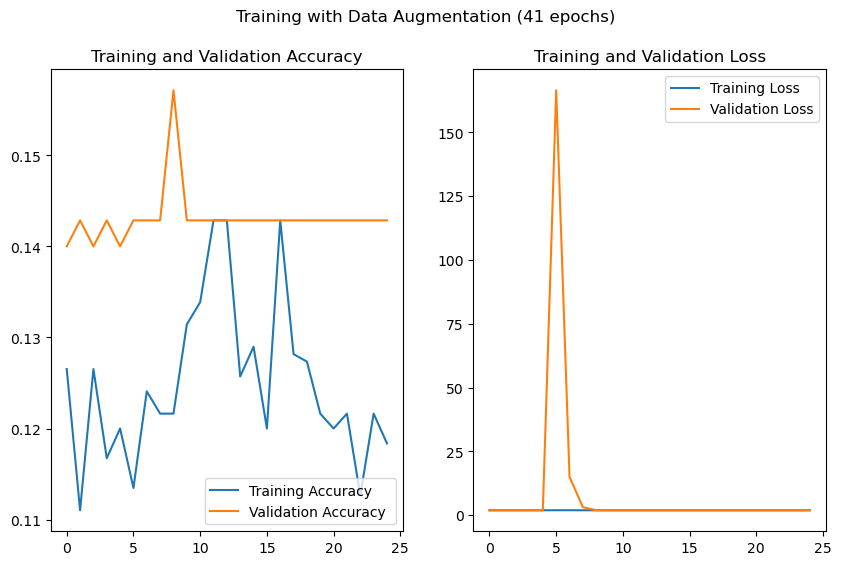

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy ')
plt.legend(loc='lower right',fontsize=10)
plt.title('Training and Validation Accuracy',fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right',fontsize=10)
plt.title('Training and Validation Loss',fontsize=12)
plt.suptitle('Training with Data Augmentation (41 epochs)',fontsize=12)
plt.show()

Comments : Increasing input size along with data augmentation, decreasing batch size does not seem to be working 

Going forward - will use 128x128x3 input size with data augmentation on a medium sized cnn 

the highest priority is, to get more data.
then use data augmentation to even increase your dataset
further reduce the complexity of your neural network if additional data doesn’t help (but I think that training will slow down with more data and validation loss will also decrease for a longer period of epochs)